In [23]:
import os
import sys
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import itertools

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split


sys.path.insert(1, '../../notes/1-Testing/fuzzy-test/python/')

%load_ext autoreload
%autoreload 2
%matplotlib widget

from fuzzy_system import Sigmoid, Gaussian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper Functions to Parse Files


In [24]:
def load_liveInfo(directory):
    # FileFormat
    #
    # avgParticlesPerCell: 0.145314
    # cutoff: 3.000000
    # domainSizeX: 115.000000
    # domainSizeY: 215.000000
    # domainSizeZ: 145.000000
    # estimatedNumNeighborInteractions: 289010
    # maxParticlesPerCell: 26
    # minParticlesPerCell: 0
    # numCells: 137592
    # numEmptyCells: 131716
    # numHaloParticles: 0
    # numParticles: 19994
    # particleSize: 128
    # particleSizeNeededByFunctor: 72
    # particlesPerBlurredCellStdDev: 0.359923
    # particlesPerCellStdDev: 0.018441
    # rebuildFrequency: 10
    # skin: 1.000000
    # threadCount: 12

    def parseText(text):
        data = {}
        for line in text.split("\n"):
            if len(line) > 0:
                key, value = line.split(":")
                data[key.strip()] = float(value.strip())
        return data

    with open(directory + "/live_info_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data


def load_best_configs(directory):
    # LineFormat
    #
    # Configuration: {Container: $A$ , CellSizeFactor: $B$ , Traversal: $C$ , Load Estimator: $D$ , Data Layout: $E$ , Newton 3: $F$}

    def parseText(text):
        rankings = []
        regex = r"Configuration: {Container: (.*) , CellSizeFactor: (.*) , Traversal: (.*) , Load Estimator: (.*) , Data Layout: (.*) , Newton 3: (.*)}"

        for line in text.split("\n"):
            match = re.search(regex, line)
            if match:
                data = {
                    "Container": match.group(1),
                    "CellSizeFactor": float(match.group(2)),
                    "Traversal": match.group(3),
                    "Load Estimator": match.group(4),
                    "Data Layout": match.group(5),
                    "Newton 3": match.group(6),
                }
                rankings.append(data)

        return rankings

    with open(directory + "/best_configs_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data

# Load Data from Folders


In [25]:
dataSet = {}

directories = []
for root, dirs, files in os.walk("./data/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


# Always load the top 3 configurations to get more training data

for directory in directories:
    liveinfo = load_liveInfo(directory)
    best_config = load_best_configs(directory)

    for i, config in enumerate(best_config):
        if not "ranking" in dataSet:
            dataSet["ranking"] = []
        dataSet["ranking"].append(i)

        for key in config:
            if not key in dataSet:
                dataSet[key] = []
            dataSet[key].append(config[key])

        for key in liveinfo:
            if not key in dataSet:
                dataSet[key] = []
            dataSet[key].append(liveinfo[key])

df = pd.DataFrame(dataSet)

# Define Interesting Data to observe


In [26]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    "numEmptyCells",
    # "numHaloParticles",
    "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
    "ranking",
]

outputs = [
    "Container",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Data Layout",
    "Newton 3",
]

# Filter Data / Outliers


In [27]:
# Remove any rows where colum lies outside 2 standard deviations
df = df[(np.abs(stats.zscore(df[inputs])) < 2).all(axis=1)]

X, y = df[inputs], df[outputs]

# Create Train and Test Data


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [29]:
pd.concat([X_train, y_train], axis=1)

avgParticlesPerCell  maxParticlesPerCell  numEmptyCells  numParticles  \
227              0.583090                  5.0         1557.0        1600.0   
365              0.528679                  6.0       134458.0      120000.0   
3756             0.217508                  1.0        33529.0        9320.0   
3281             2.871264                 15.0          904.0       19694.0   
2639             0.000000                  0.0        74088.0           0.0   
...                   ...                  ...            ...           ...   
2126             0.002519                  1.0        19407.0          49.0   
1287             0.004144                  2.0        73782.0         307.0   
1372             0.250206                  1.0        22775.0        7600.0   
1586             4.076557                  6.0         5569.0      150800.0   
956              0.000000                  0.0        74088.0           0.0   

      particlesPerCellStdDev  ranking           Container  \
227                 0.025473       27         LinkedCells   
365                 0.002912       15         LinkedCells   
3756                0.009163       34    VerletListsCells   
3281                0.009379        9         LinkedCells   
2639                0.000000        5  VerletClusterLists   
...                      ...      ...                 ...   
2126                0.142677       42         LinkedCells   
1287                0.057141       49         LinkedCells   
1372                0.009933       34    VerletListsCells   
1586                0.002625       48  VerletClusterLists   
956                 0.000000       14  VerletClusterLists   

                  Traversal Data Layout  Newton 3  
227                  lc_c08         AoS   enabled  
365           lc_sliced_c02         AoS  disabled  
3756                vlc_c18         SoA  disabled  
3281              lc_sliced         SoA   enabled  
2639                vcl_c06         AoS  disabled  
...                     ...         ...       ...  
2126          lc_sliced_c02         SoA   enabled  
1287     lc_sliced_balanced         SoA  disabled  
1372                vlc_c18         SoA  disabled  
1586  vcl_cluster_iteration         AoS  disabled  
956                 vcl_c06         AoS  disabled  

[2430 rows x 10 columns]

# Make some plots about the data


/tmp/ipykernel_254874/693119037.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(1, len(y_train.columns))


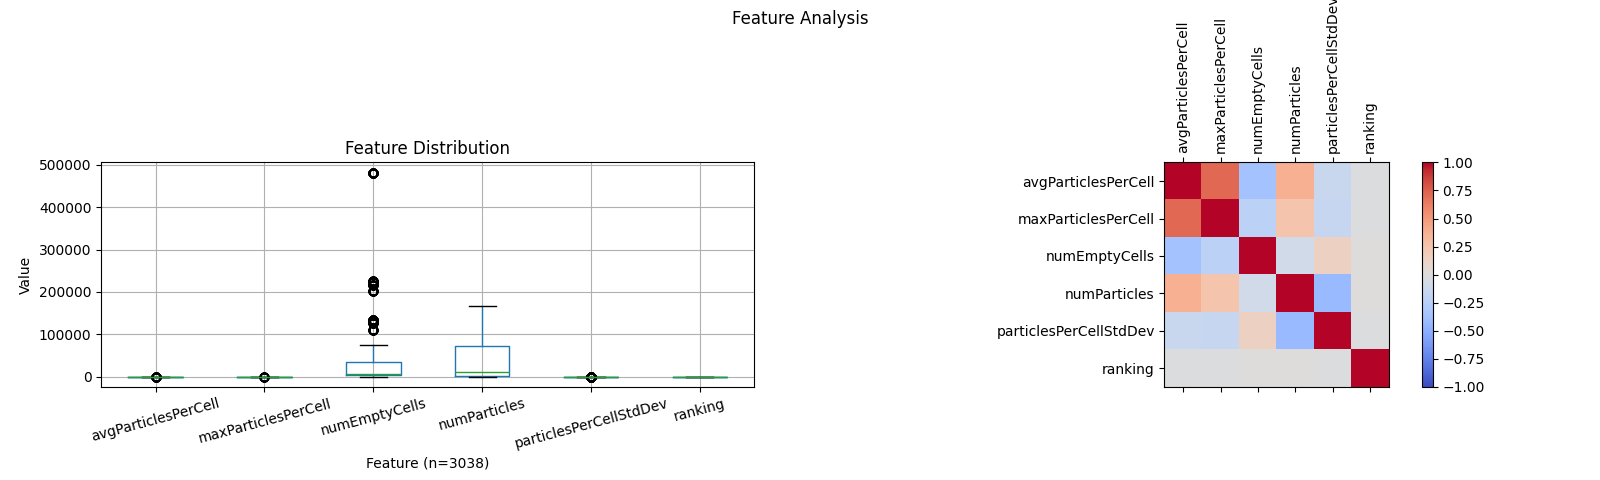

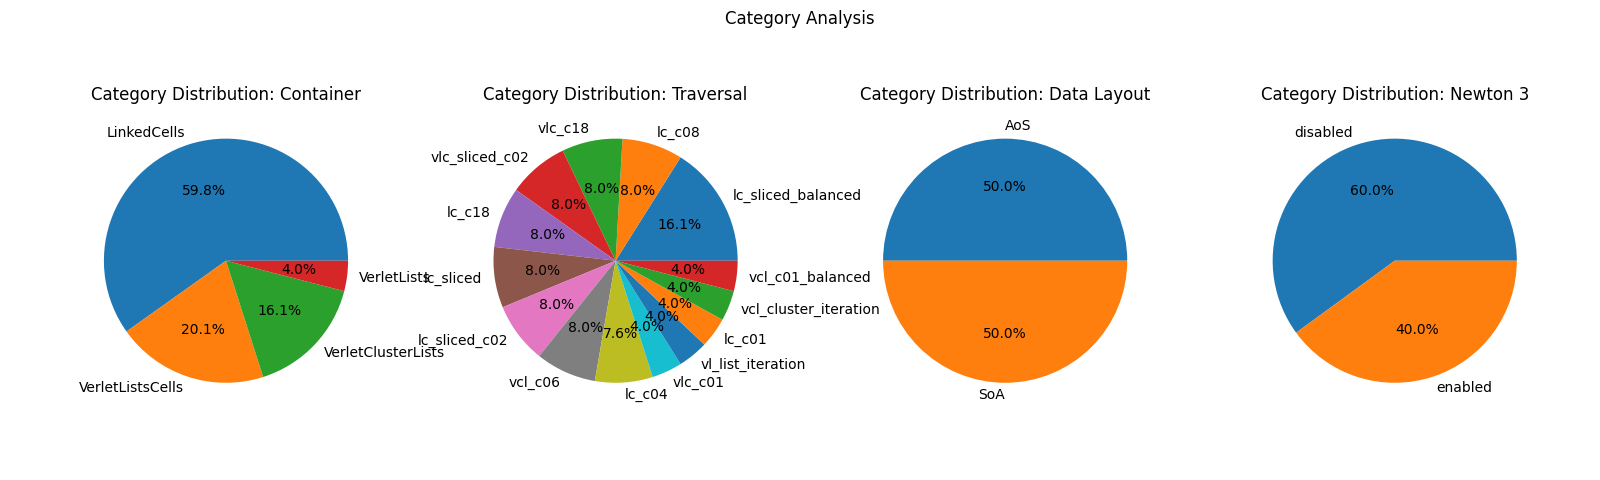

In [30]:
# Row 1
fig, ax1 = plt.subplots(1, 2)
fig.suptitle("Feature Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=5)
# Axis 1 Boxplot for each feature

boxplot = X.boxplot(ax=ax1[0], showfliers=True)
ax1[0].set_title("Feature Distribution")
ax1[0].set_ylabel("Value")
ax1[0].set_xlabel(f"Feature (n={X.shape[0]})")
ax1[0].set_xticklabels(X.columns, rotation=15)

# Correlation Matrix
corr = X.corr()
cax = ax1[1].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax1[1].set_xticks(range(len(X.columns)))
ax1[1].set_yticks(range(len(X.columns)))
ax1[1].set_xticklabels(X.columns, rotation=90)
ax1[1].set_yticklabels(X.columns)
ax1[1].set_title("Correlation Matrix")

# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)
for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()
    ax1[i].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Helper Functions to make plots


In [31]:
def scatter_2d(df, x_name, y_name, label_name, filter=None):
    fig = plt.figure()
    fig.suptitle(f"2D Scatter Plot: {x_name} vs {y_name} for {label_name}")
    ax = fig.add_subplot(111)

    x = df[x_name]
    y = df[y_name]
    labels = df[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
        t.set_rotation(45)

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend()


def scatter_3d(df, x_name, y_name, z_name, label_name, filter=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f"3D Scatter Plot: {x_name} vs {
                 y_name} vs {z_name} for {label_name}")

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]
    labels = df[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c], z[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]:
        t.set_rotation(45)

    # format ticklabes
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-4, 2))

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend()

# Automatic Rule Learning


In [32]:
class Condition:
    def __init__(self, feature, operator, value):
        self.feature = feature
        self.operator = operator
        self.value = value

    def __str__(self):
        def format_value(x): return '"' + x + '"' if isinstance(x, str) else x

        return f"({format_value(self.feature)} {self.operator} {format_value(self.value)})"


class Rule:
    # Condions are combined with AND, while the elements in a condition are combined with OR
    def __init__(self, conditions: list[list[Condition]], prediction):
        self.conditions = conditions
        self.prediction = prediction

    def __str__(self):
        return f"if {' && '.join(['(' + ' || '.join([str(c) for c in cond]) + ')' for cond in self.conditions])} then {self.prediction}"

# Decision Tree


In [33]:
def train_decision_tree(df, inputs, outputs, *args, **kwargs):
    labels = df[outputs]
    encoder = preprocessing.LabelEncoder()
    labels_enc = encoder.fit_transform(labels)

    ccp_alpha = kwargs.get("ccp_alpha", 0.0)

    # scale cc_alpha to the number of classes
    if ccp_alpha > 0:
        ccp_alpha = ccp_alpha / (np.log(3+len(np.unique(labels_enc))))
        kwargs["ccp_alpha"] = ccp_alpha

    model = DecisionTreeClassifier(random_state=1, *args, **kwargs)

    model.fit(df[inputs], labels_enc)

    score = model.score(df[inputs], labels_enc)

    return (model, encoder), score


def extract_rules_from_decision_tree(tree, feature_names, label_name, class_names) -> list[Rule]:
    tree_ = tree.tree_

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != -2:
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1.append(Condition(name, "<=", np.round(threshold, 3)))
            recurse(tree_.children_left[node], p1, paths)
            p2.append(Condition(name, ">", np.round(threshold, 3)))
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        conditions = list(map(lambda x: [x], path[:-1]))

        classes = path[-1][0][0]
        l = np.argmax(classes)
        result = class_names[l]

        rules.append(Rule(conditions, Condition(label_name, "==", result)))

    return rules


def get_split_dimensions(tree, feature_names):
    tree_ = tree.tree_
    return set([feature_names[i] for i in tree_.feature if i != -2])

# Helper Functions to learn and plot Decision Trees


In [34]:
def find_rulesNd(df, inputs, label_name, *args, **kwargs):
    (model, pre), score = train_decision_tree(
        df, inputs, label_name, *args, **kwargs)

    rules = extract_rules_from_decision_tree(
        model, inputs, label_name, pre.classes_)

    return (model, pre), inputs, rules, score


markers = ['o', 'x', 's', 'v', '^']


def plut_rules_1d(df, model, encoder, inputs, used_inputs, label_name, score):
    (x_name,) = used_inputs
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(16)
    fig.suptitle(f"{label_name}: {x_name} (score={score:.2f})")

    min_x = np.inf
    max_x = -np.inf

    for i, c in enumerate(np.unique(encoder.classes_)):

        ax[0].scatter(df[x_name][df[label_name] == c], np.zeros_like(df[x_name][df[label_name] == c]),
                      label=c, marker=markers[i % len(markers)])

        min_x = min(min_x, df[x_name][df[label_name] == c].min())
        max_x = max(max_x, df[x_name][df[label_name] == c].max())

    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 100),
                         np.linspace(-1, 1, 100))

    data = {
        x_name: xx.ravel(),
    }

    for col in inputs:
        if col not in used_inputs:
            data[col] = np.zeros_like(xx.ravel())

    df_pred = pd.DataFrame(data)[inputs]

    Z = model.predict(df_pred)
    Z = Z.reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4)

    ax[0].set_xlabel(x_name)
    # disable y
    ax[0].get_yaxis().set_visible(False)

    ax[0].legend()

    plot_tree(model, ax=ax[1], feature_names=inputs,
              class_names=encoder.classes_)


def plot_rules_2d(df, model, encoder, inputs, used_inputs, label_name, score):
    (x_name, y_name) = used_inputs

    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(16)
    fig.suptitle(f"{label_name}: {x_name} vs {y_name} (score={score:.2f})")

    min_x = np.inf
    max_x = -np.inf

    min_y = np.inf
    max_y = -np.inf

    for i, c in enumerate(np.unique(encoder.classes_)):

        ax[0].scatter(df[x_name][df[label_name] == c], df[y_name][df[label_name] == c],
                      label=c, marker=markers[i % len(markers)])

        min_x = min(min_x, df[x_name][df[label_name] == c].min())
        max_x = max(max_x, df[x_name][df[label_name] == c].max())

        min_y = min(min_y, df[y_name][df[label_name] == c].min())
        max_y = max(max_y, df[y_name][df[label_name] == c].max())

    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 100),
                         np.linspace(min_y, max_y, 100))

    data = {
        x_name: xx.ravel(),
        y_name: yy.ravel()
    }

    for col in inputs:
        if col not in used_inputs:
            data[col] = np.zeros_like(xx.ravel())

    df_pred = pd.DataFrame(data)[inputs]

    Z = model.predict(df_pred)
    Z = Z.reshape(xx.shape)

    ax[0].contourf(xx, yy, Z, alpha=0.4)

    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel(y_name)
    ax[0].legend()

    plot_tree(model, ax=ax[1], feature_names=inputs,
              class_names=encoder.classes_)


def plot_rules_3d(df, model, encoder, inputs, used_inputs, label_name, score):
    (x_name, y_name, z_name) = used_inputs

    fig = plt.figure()
    fig.set_figwidth(16)
    fig.suptitle(f"{label_name}: {x_name} vs {
                 y_name} vs {z_name} (score={score:.2f})")

    ax = fig.add_subplot(121, projection='3d')

    for i, c in enumerate(np.unique(encoder.classes_)):
        ax.scatter(df[x_name][df[label_name] == c], df[y_name][df[label_name] == c], df[z_name][df[label_name] == c],
                   label=c, marker=markers[i % len(markers)])

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend()

    ax = fig.add_subplot(122)

    plot_tree(model, ax=ax,  feature_names=inputs,
              class_names=encoder.classes_)


def plot_rules_Nd(df, model, encoder, inputs, used_inputs, label, score):
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.suptitle(f"{label}: (score={score:.2f})")

    ax = fig.add_subplot(111)

    plot_tree(model, ax=ax,  feature_names=X_train.columns,
              class_names=encoder.classes_)

# Train Decision Tree and Extract Rules

In [35]:
# how many of the ranked solutions should be used (1=> only use best prediction)
TOP_K_SAMPLES = 1

# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4]

CCP_ALPHA = {
    "Container": 0.2,
    "Traversal": 0.06,
    "Data Layout": 0.15,
    "Newton 3": 0.13,

}

# maximum depth of the decision tree
MAX_DEPTH = 5

# how many trees should be used to create rules for each label
TOP_K_MODELS_PER_LABEL = 2

Training on 52 samples
Number of rules 40:
	Container (5 rules)
	Traversal (26 rules)
	Data Layout (5 rules)
	Newton 3 (4 rules)


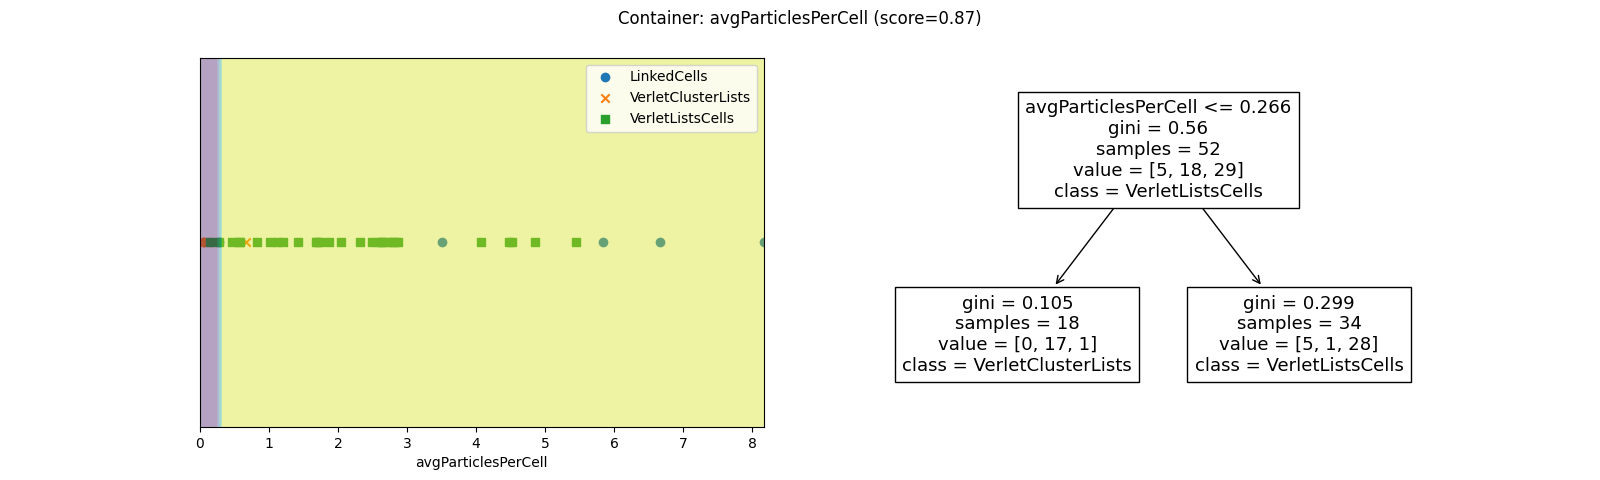

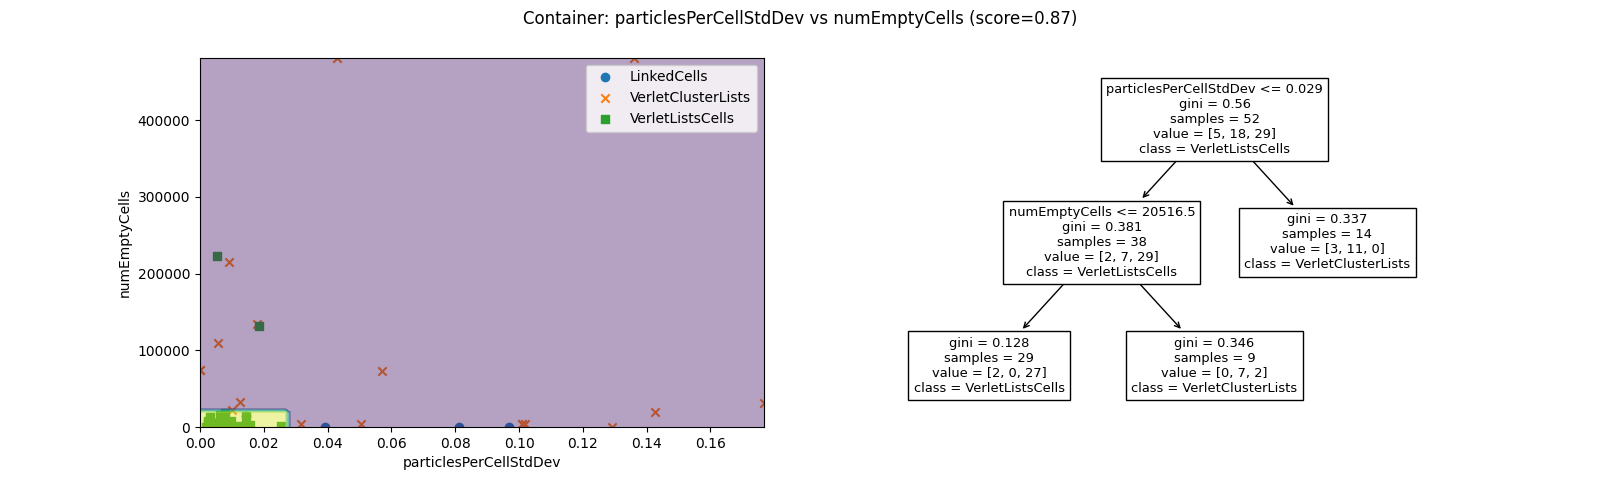

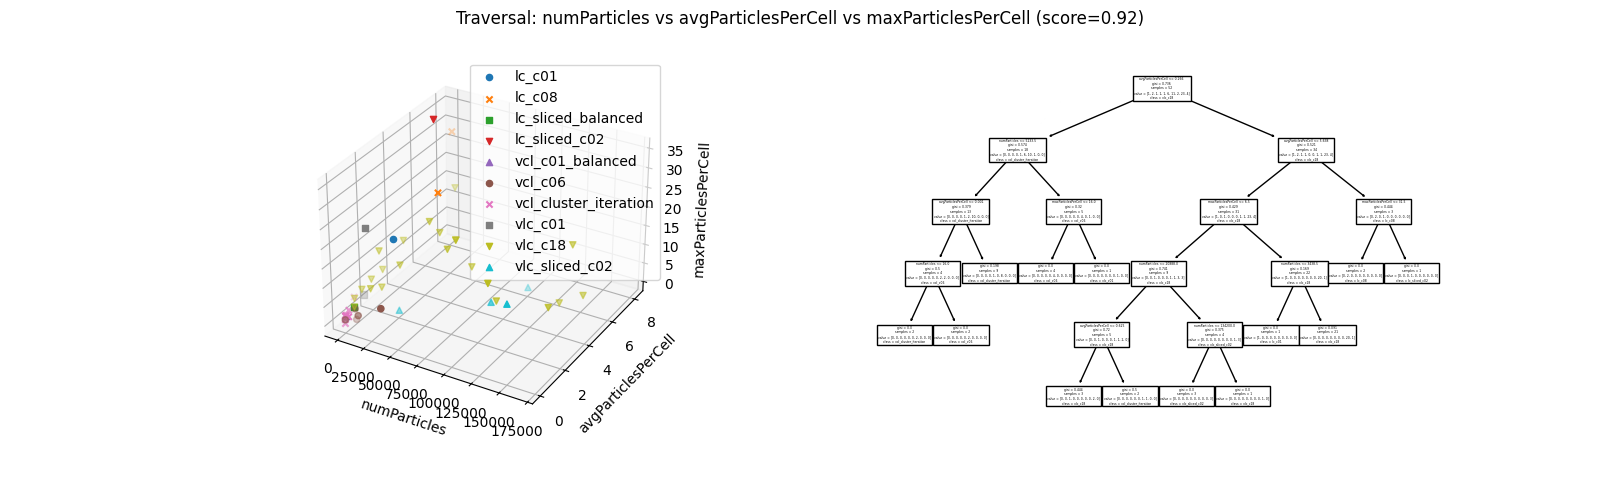

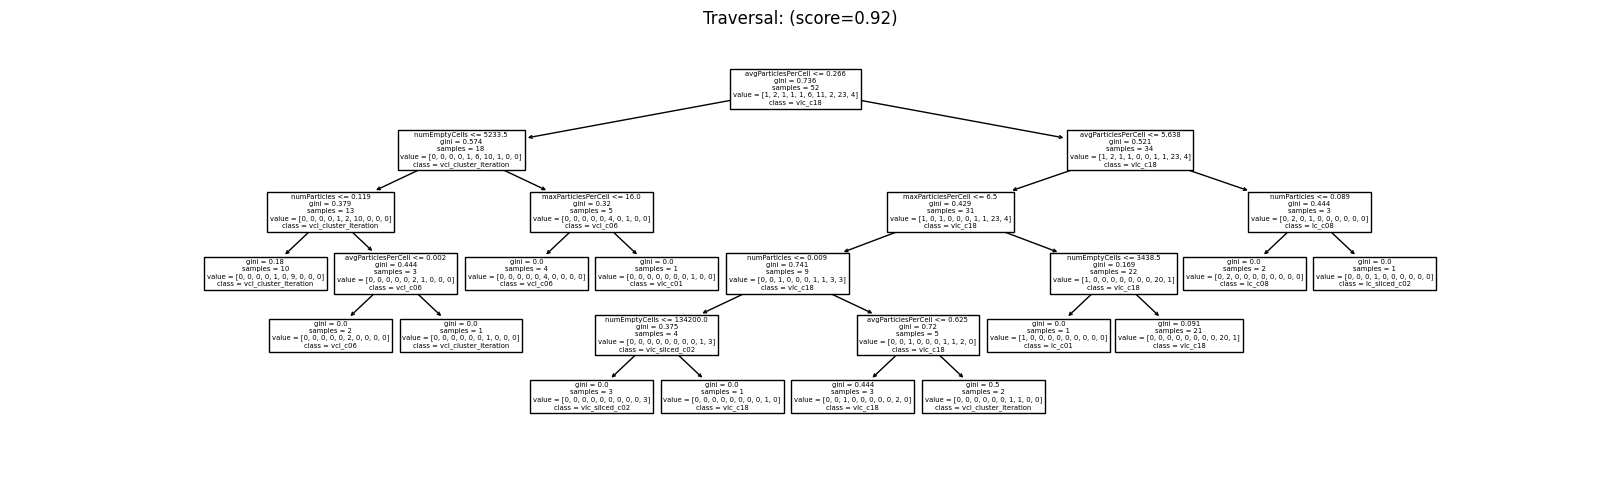

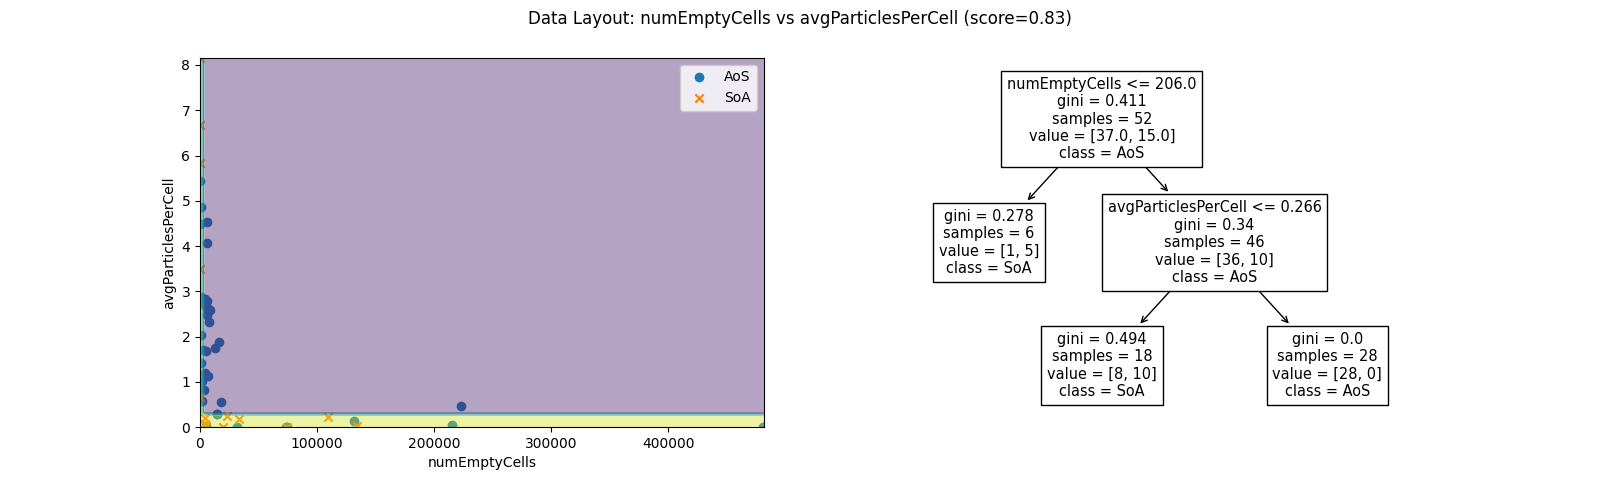

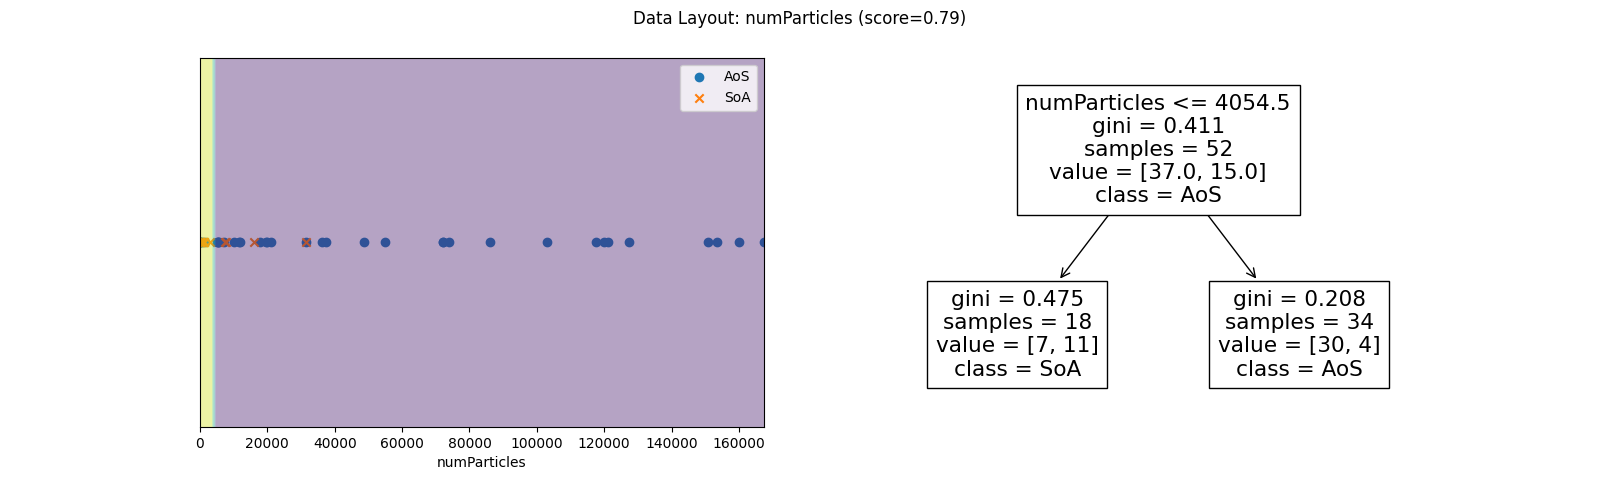

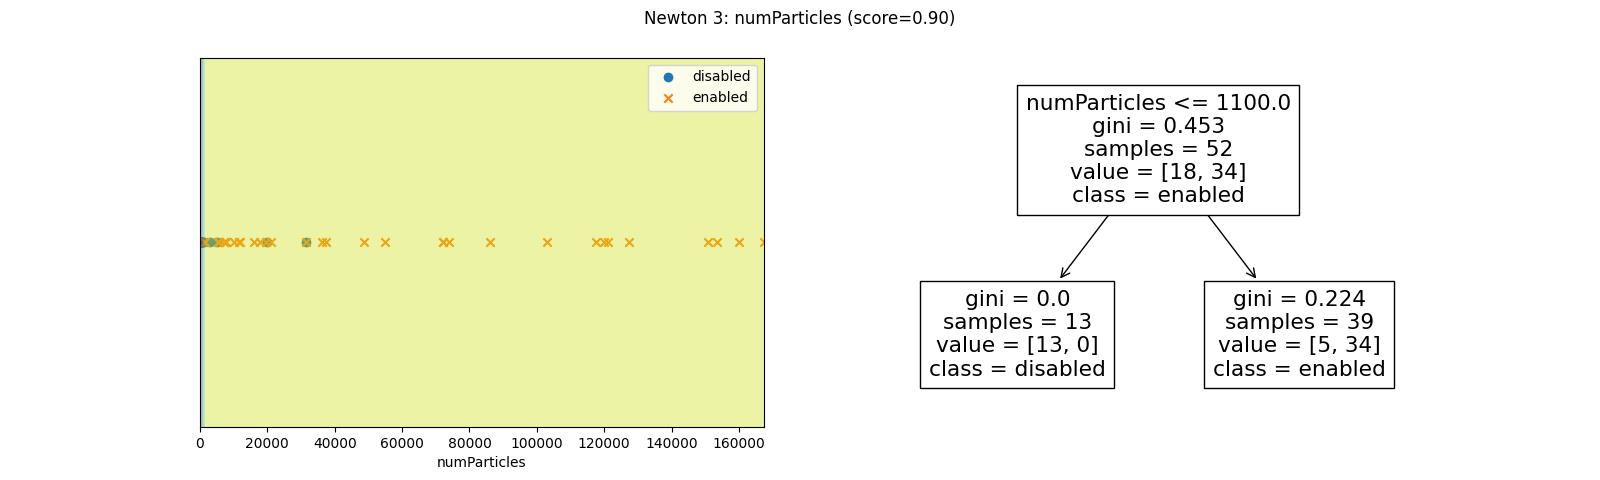

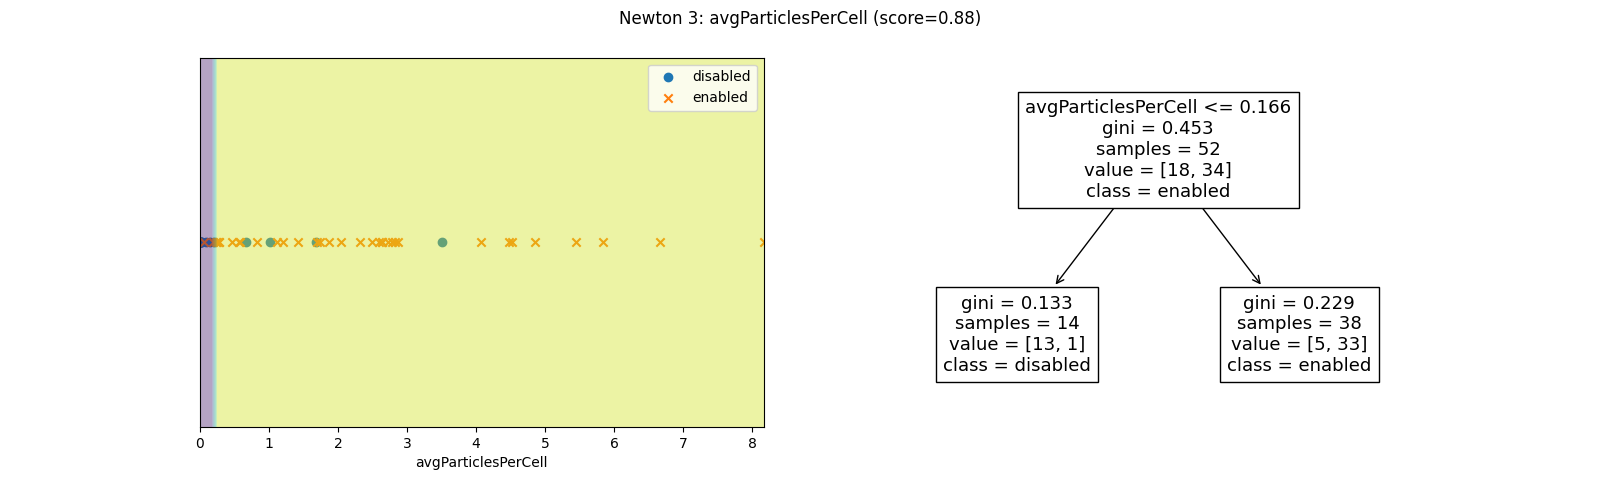

In [36]:
df_filtered = pd.concat([X_train, y_train], axis=1)

df_filtered = df_filtered[df_filtered["ranking"] < TOP_K_SAMPLES]

print(f"Training on {df_filtered.shape[0]} samples")

tree_fits: dict[str, list[tuple[tuple[DecisionTreeClassifier,
                                      preprocessing.LabelEncoder], list[float], list[Rule], float]]] = {}


for label in y_train.columns:
    for comb_size in POSSIBLE_NUMBER_OF_COMBINATIONS:

        for comb in itertools.combinations(X_train.columns, comb_size):

            tree_fit = find_rulesNd(
                df_filtered, list(comb), label, ccp_alpha=CCP_ALPHA[label], max_depth=MAX_DEPTH)

            if label not in tree_fits:
                tree_fits[label] = []

            tree_fits[label].append(tree_fit)


auto_rules = {}


for label in tree_fits:
    models = tree_fits[label]

    distinct_models = []
    seen_inputs = set()
    for ((model, encoder), inputs, rules, score) in models:
        used_inputs = frozenset(get_split_dimensions(model, inputs))

        if used_inputs not in seen_inputs:
            distinct_models.append(((model, encoder), inputs, rules, score))
            seen_inputs.add(used_inputs)

    # sort by score
    best_models = sorted(distinct_models, key=lambda x: x[3], reverse=True)[
        :TOP_K_MODELS_PER_LABEL]

    if label not in auto_rules:
        auto_rules[label] = []

    # plot the best models
    for (model, encoder), inputs, rules, score in best_models:

        used_inputs = get_split_dimensions(model, inputs)

        if (len(used_inputs) == 1):
            plut_rules_1d(df_filtered, model, encoder,
                          inputs, used_inputs, label, score)
        elif (len(used_inputs) == 2):
            plot_rules_2d(df_filtered, model, encoder,
                          inputs, used_inputs, label, score)
        elif (len(used_inputs) == 3):
            plot_rules_3d(df_filtered, model, encoder,
                          inputs, used_inputs, label, score)
        else:
            plot_rules_Nd(df_filtered, model, encoder,
                          inputs, used_inputs, label, score)

        auto_rules[label].extend(rules)

print(f"Number of rules {sum([len(rules) for rules in auto_rules.values()])}:")
for label, rules in auto_rules.items():
    print(f"\t{label} ({len(rules)} rules)")

# Create Plots for Membership Functions


Each Interval between two boundaries of the Decision Tree becomes a Membership Function.


In [37]:
dimensionsBoundariesAll: dict[str, list[float]] = {}

for (label, rules) in auto_rules.items():
    for rule in rules:
        for andCond in rule.conditions:
            for condition in andCond:
                feature = condition.feature
                value = condition.value

                if feature not in dimensionsBoundariesAll:
                    dimensionsBoundariesAll[feature] = [-np.inf, np.inf]
                else:
                    dimensionsBoundariesAll[feature].append(value)

# sort and remove duplicates
for feature in dimensionsBoundariesAll:
    dimensionsBoundariesAll[feature] = sorted(
        list(set(dimensionsBoundariesAll[feature])))


# Clean up boundaries, remove close values

dimensionsBoundaries: dict[str, list[float]] = {}
for feature in dimensionsBoundariesAll:
    boundaries = sorted(dimensionsBoundariesAll[feature])

    average_diff = np.mean(
        list(filter(lambda x: x != np.inf, np.diff(boundaries))))

    new_boundaries = [boundaries[0]]
    for i in range(1, len(boundaries)):
        diff = boundaries[i] - new_boundaries[-1]
        if diff < 0.2 * average_diff:
            continue
        new_boundaries.append(boundaries[i])

    dimensionsBoundaries[feature] = new_boundaries

# Print out the cleaned
for feature in dimensionsBoundaries:
    print(f"{feature}: {dimensionsBoundariesAll[feature]}")
    print(f"{feature}: {dimensionsBoundaries[feature]}")
    print()

avgParticlesPerCell: [-inf, 0.001, 0.002, 0.166, 0.266, 0.625, 5.638, inf]
avgParticlesPerCell: [-inf, 0.001, 0.266, 0.625, 5.638, inf]

particlesPerCellStdDev: [-inf, 0.009, 0.029, 0.089, 0.119, inf]
particlesPerCellStdDev: [-inf, 0.009, 0.029, 0.089, 0.119, inf]

numEmptyCells: [-inf, 206.0, 20516.5, inf]
numEmptyCells: [-inf, 206.0, 20516.5, inf]

maxParticlesPerCell: [-inf, 6.5, 16.0, 31.5, inf]
maxParticlesPerCell: [-inf, 6.5, 16.0, 31.5, inf]

numParticles: [-inf, 16.0, 1100.0, 3438.5, 4054.5, 5233.5, 20888.0, 134200.0, inf]
numParticles: [-inf, 16.0, 5233.5, 20888.0, 134200.0, inf]



# Create Activation Functions


In [38]:
def plot_linguistic_variable(df, dimensionsBoundaries, inputRangeMembershipFunctions, dim):
    fig, ax1 = plt.subplots(1, 1)
    ax2 = ax1.twinx()

    fig.suptitle(f"Dimension: {dim}")
    fig.set_figwidth(10)

    ax1.hist(df[dim], bins=40, alpha=0.5, label="Data", align='mid')

    for rule_range in sorted(dimensionsBoundaries[dim]):
        ax1.axvline(x=rule_range, color='r', linestyle='--',
                    label=f"Boundary: {rule_range}")

    min_x = df[dim].min()
    max_x = df[dim].max()

    if type(min_x) == str:
        min_x = 0

    if type(max_x) == str:
        max_x = len(dimensionsBoundaries[dim])-1

    inputs = np.linspace(min_x-0.05*(max_x-min_x),
                         max_x+0.05*(max_x-min_x), 1000)

    for i, f in enumerate(inputRangeMembershipFunctions[dim]):
        ax2.plot(inputs, f.function(inputs), label=f)

    ax1.set_xlabel(dim)
    ax1.set_ylabel("Frequency")
    ax1.legend(loc='upper right')

    ax2.set_ylabel("Activation")
    ax2.legend(loc='lower right')

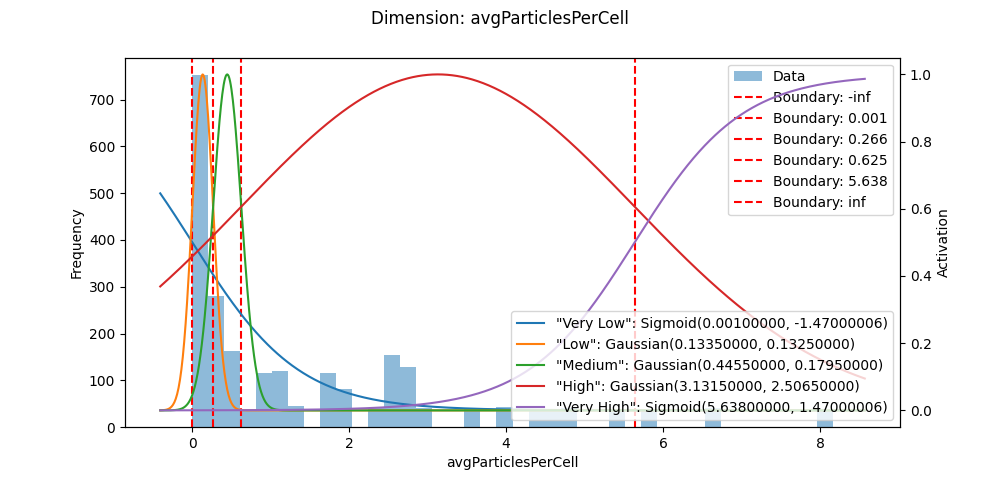

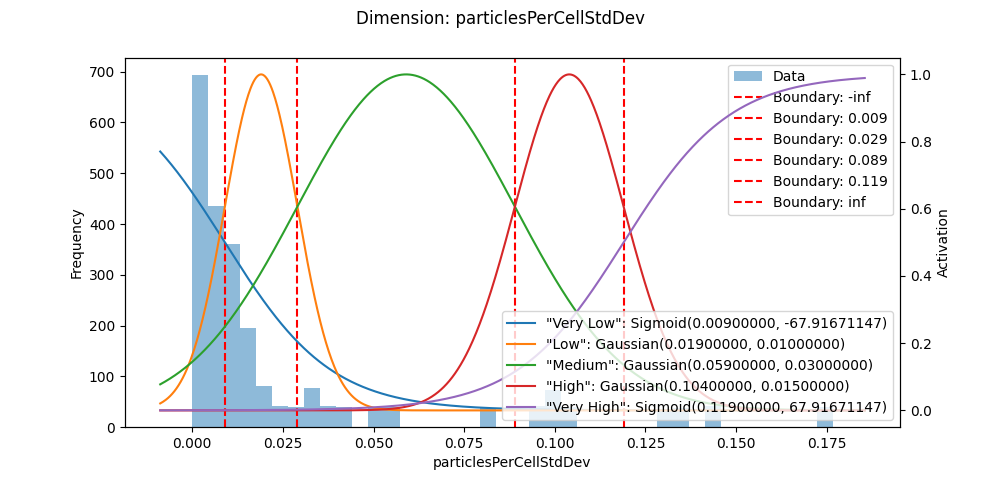

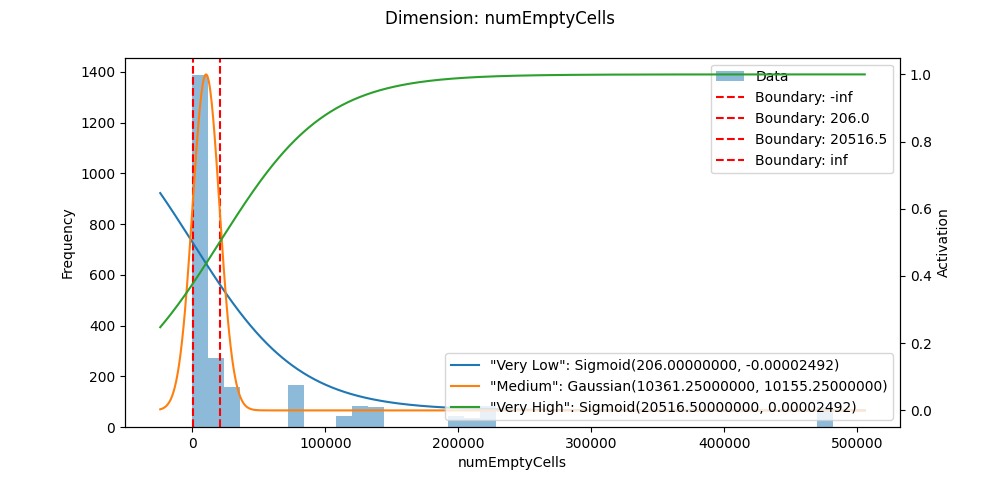

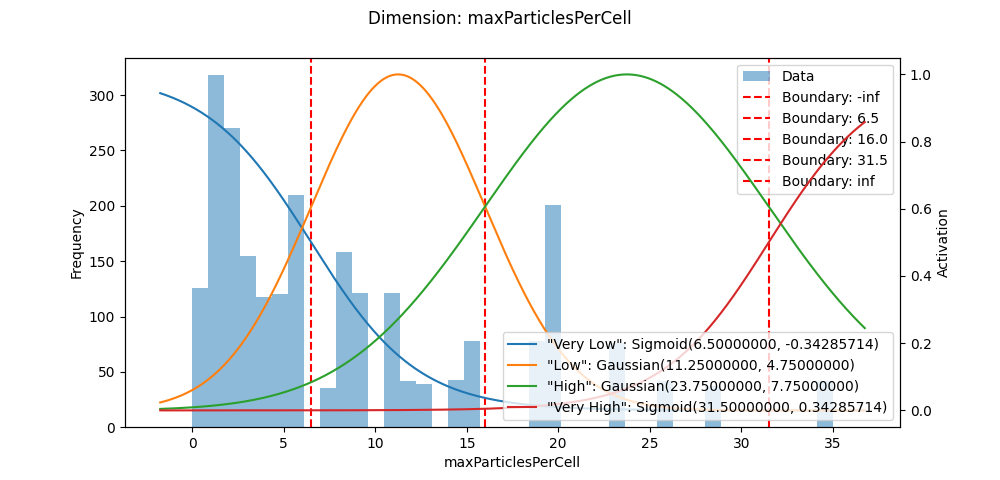

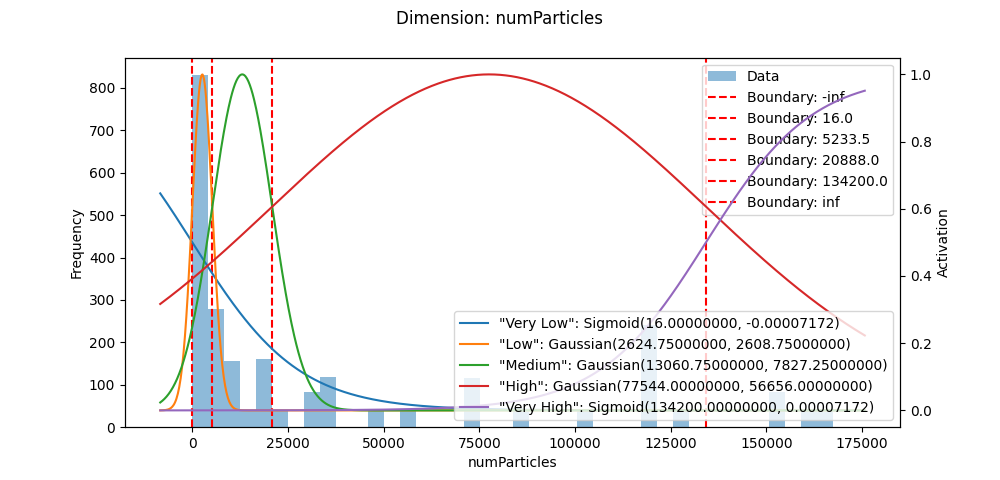

In [39]:
inputRangeMembershipFunctions: dict[str, list] = {}

linguisticDescriptions = ["Extremely Low", "Very Low", "Low",
                          "Medium", "High", "Very High", "Extremely High"]


for dim in dimensionsBoundaries:
    inputRangeMembershipFunctions[dim] = []

    boundaries = sorted(dimensionsBoundaries[dim])

    already_chosen_names = set()

    for i, (curr, next) in enumerate(zip(boundaries, boundaries[1:])):
        percentage = (i+1) / len(boundaries)
        i = int(percentage * len(linguisticDescriptions))
        name = linguisticDescriptions[i]

        if name in already_chosen_names:
            name = name + " " + str(i)
        already_chosen_names.add(name)

        if (next-curr == np.inf):
            boundary = curr if curr != -np.inf else next

            neighbour_range = boundaries[i -
                                         1:i+1] if i > 0 else boundaries[i+1:i+3]

            std = (neighbour_range[1] - neighbour_range[0]) / 2 if len(
                neighbour_range) == 2 else np.inf
            if np.abs(std) == np.inf:
                std = (X_train[dim].max() - X_train[dim].min()) / 2

            flipped = -1 if curr == -np.inf else 1
            std *= flipped

            inputRangeMembershipFunctions[dim].append(
                Sigmoid(name, boundary, 6/std))
        else:
            mean = (curr + next) / 2
            std = (next - curr) / 2
            inputRangeMembershipFunctions[dim].append(
                Gaussian(name, mean, std))

    plot_linguistic_variable(X_train, dimensionsBoundaries,
                             inputRangeMembershipFunctions, dim)

# Create Output Membership Functions

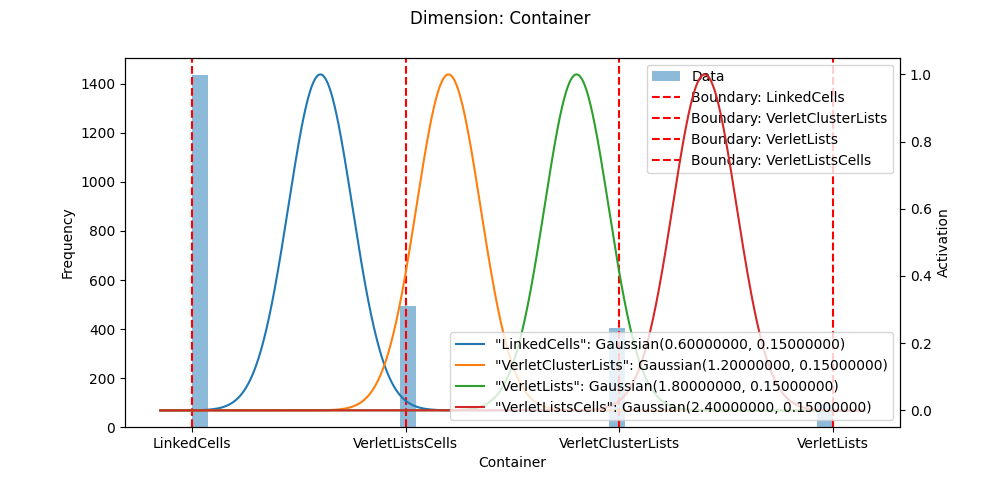

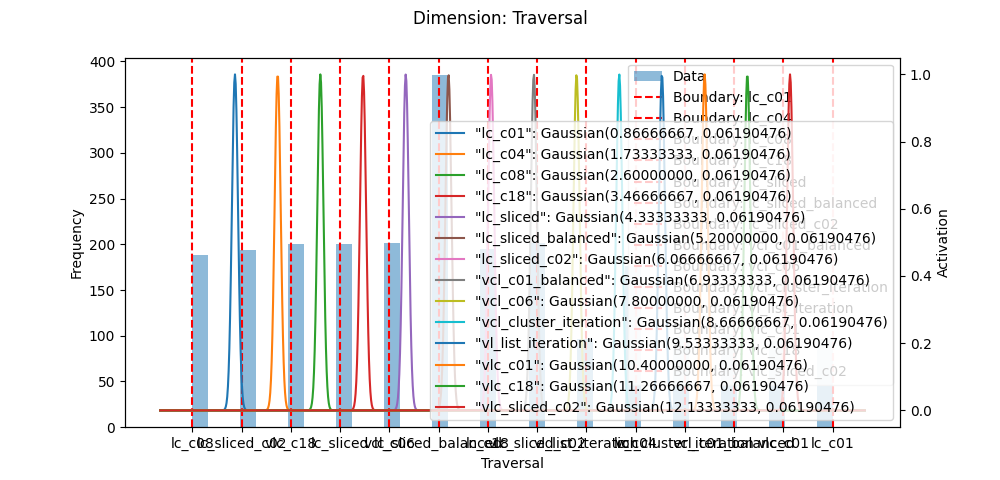

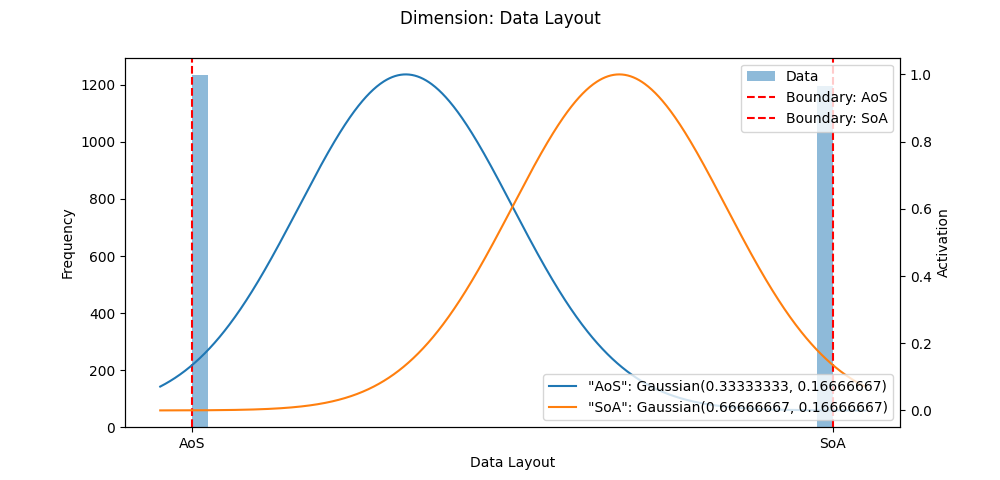

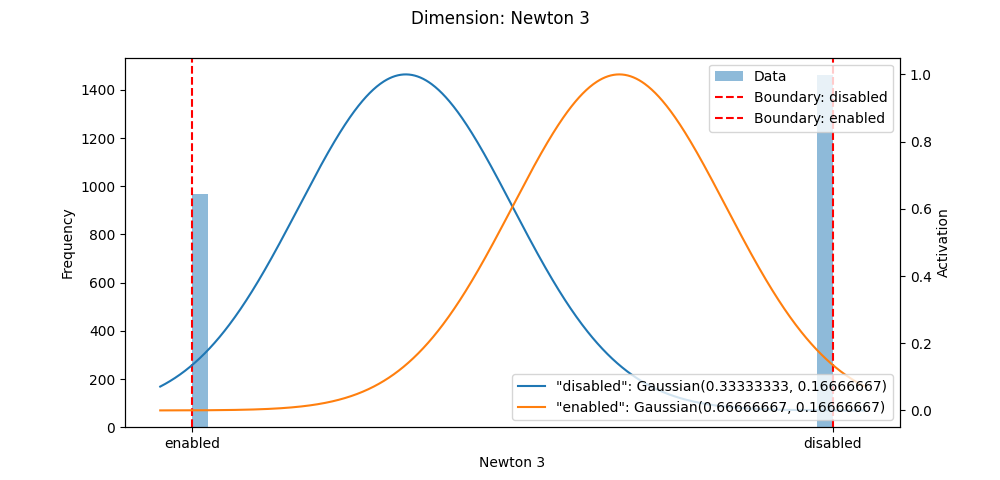

In [40]:
outputRangeMembershipFunctions: dict[str, list] = {}

for col in y_train.columns:

    outputRangeMembershipFunctions[col] = []

    values = sorted(y_train[col].unique())

    for i, entry in enumerate(values):
        spacing = (len(values)-1)/(len(values)+1)
        mean = (i+1)*spacing
        std = (spacing/len(values))
        outputRangeMembershipFunctions[col].append(Gaussian(entry, mean, std))

    plot_linguistic_variable(
        y_train, {col: values}, outputRangeMembershipFunctions, col)

# Create Fuzzy Rules from Decision Tree Rules


Rules of the decision tree are mapped to Fuzzy Rules.

E.g if the Decision Tree Rule is: `If A > 5 then C` then the Fuzzy Rule is: `If {Or combination of [A == m for m in (List of all membership functions with mean > 5)]} then C`


In [41]:
fuzzy_rules = []
for label, rules in auto_rules.items():
    for rule in rules:
        new_conditions = []
        for and_cond in rule.conditions:
            or_condition = []
            for condition in and_cond:
                feature = condition.feature
                operator = condition.operator
                value = condition.value

                applicable_functionsR = list(filter(
                    lambda f: eval(f"f.peak() {operator} {value}"), inputRangeMembershipFunctions[feature]))

                applicable_functionsL = list(filter(
                    lambda f: eval(f"{value} {operator} f.peak()"), inputRangeMembershipFunctions[feature]))

                if len(applicable_functionsR) < len(applicable_functionsL):
                    for f in applicable_functionsR:
                        or_condition.append(
                            Condition(feature, "==", f.linguistic_term))
                else:
                    for f in applicable_functionsL:
                        new_conditions.append([
                            Condition(feature, "!=", f.linguistic_term)])

            if len(or_condition) > 0:
                new_conditions.append(or_condition)

        new_rule = Rule(new_conditions, rule.prediction)

        fuzzy_rules.append(new_rule)

In [42]:
with open("fuzzy-inputs.txt", "w") as f:
    for axis in inputRangeMembershipFunctions:
        f.write(f"Axis: \"{axis}\" range: ({
                X_train[axis].min():.2f}, {X_train[axis].max():.2f})\n")
        for func in inputRangeMembershipFunctions[axis]:
            f.write(f"\t{func}\n")
        f.write("\n")

with open("fuzzy-inputs.txt", "r") as f:
    print(f.read())

Axis: "avgParticlesPerCell" range: (0.00, 8.16)
	"Very Low": Sigmoid(0.00100000, -1.47000006)
	"Low": Gaussian(0.13350000, 0.13250000)
	"Medium": Gaussian(0.44550000, 0.17950000)
	"High": Gaussian(3.13150000, 2.50650000)
	"Very High": Sigmoid(5.63800000, 1.47000006)

Axis: "particlesPerCellStdDev" range: (0.00, 0.18)
	"Very Low": Sigmoid(0.00900000, -67.91671147)
	"Low": Gaussian(0.01900000, 0.01000000)
	"Medium": Gaussian(0.05900000, 0.03000000)
	"High": Gaussian(0.10400000, 0.01500000)
	"Very High": Sigmoid(0.11900000, 67.91671147)

Axis: "numEmptyCells" range: (0.00, 481581.00)
	"Very Low": Sigmoid(206.00000000, -0.00002492)
	"Medium": Gaussian(10361.25000000, 10155.25000000)
	"Very High": Sigmoid(20516.50000000, 0.00002492)

Axis: "maxParticlesPerCell" range: (0.00, 35.00)
	"Very Low": Sigmoid(6.50000000, -0.34285714)
	"Low": Gaussian(11.25000000, 4.75000000)
	"High": Gaussian(23.75000000, 7.75000000)
	"Very High": Sigmoid(31.50000000, 0.34285714)

Axis: "numParticles" range: (0.00

In [43]:
with open("fuzzy-outputs.txt", "w") as f:
    for axis in outputRangeMembershipFunctions:
        f.write(f"Axis: \"{axis}\" range: ({0:.2f}, {(len(outputRangeMembershipFunctions[axis])-1):.2f})\n")
        for func in outputRangeMembershipFunctions[axis]:
            f.write(f"\t{func}\n")
        f.write("\n")

with open("fuzzy-outputs.txt", "r") as f:
    print(f.read())

Axis: "Container" range: (0.00, 3.00)
	"LinkedCells": Gaussian(0.60000000, 0.15000000)
	"VerletClusterLists": Gaussian(1.20000000, 0.15000000)
	"VerletLists": Gaussian(1.80000000, 0.15000000)
	"VerletListsCells": Gaussian(2.40000000, 0.15000000)

Axis: "Traversal" range: (0.00, 13.00)
	"lc_c01": Gaussian(0.86666667, 0.06190476)
	"lc_c04": Gaussian(1.73333333, 0.06190476)
	"lc_c08": Gaussian(2.60000000, 0.06190476)
	"lc_c18": Gaussian(3.46666667, 0.06190476)
	"lc_sliced": Gaussian(4.33333333, 0.06190476)
	"lc_sliced_balanced": Gaussian(5.20000000, 0.06190476)
	"lc_sliced_c02": Gaussian(6.06666667, 0.06190476)
	"vcl_c01_balanced": Gaussian(6.93333333, 0.06190476)
	"vcl_c06": Gaussian(7.80000000, 0.06190476)
	"vcl_cluster_iteration": Gaussian(8.66666667, 0.06190476)
	"vl_list_iteration": Gaussian(9.53333333, 0.06190476)
	"vlc_c01": Gaussian(10.40000000, 0.06190476)
	"vlc_c18": Gaussian(11.26666667, 0.06190476)
	"vlc_sliced_c02": Gaussian(12.13333333, 0.06190476)

Axis: "Data Layout" range

In [44]:
print(f"Number of Automatic Fuzzy Rules: {len(fuzzy_rules)}\n")

with open("fuzzy-rules.txt", "w") as f:
    for rule in fuzzy_rules:
        f.write(f"{rule}\n")

with open("fuzzy-rules.txt", "r") as f:
    print(f.read())

Number of Automatic Fuzzy Rules: 40

if (("avgParticlesPerCell" != "Very Low")) && (("avgParticlesPerCell" != "Low")) then ("Container" == "VerletListsCells")
if (("avgParticlesPerCell" == "Very Low") || ("avgParticlesPerCell" == "Low")) then ("Container" == "VerletClusterLists")
if (("particlesPerCellStdDev" == "Very Low") || ("particlesPerCellStdDev" == "Low")) && (("numEmptyCells" != "Very High")) then ("Container" == "VerletListsCells")
if (("particlesPerCellStdDev" != "Very Low")) && (("particlesPerCellStdDev" != "Low")) then ("Container" == "VerletClusterLists")
if (("particlesPerCellStdDev" == "Very Low") || ("particlesPerCellStdDev" == "Low")) && (("numEmptyCells" == "Very High")) then ("Container" == "VerletClusterLists")
if (("avgParticlesPerCell" != "Very Low")) && (("avgParticlesPerCell" != "Low")) && (("avgParticlesPerCell" != "Very High")) && (("maxParticlesPerCell" != "Very Low")) && (("numParticles" != "Very Low")) && (("numParticles" != "Low")) then ("Traversal" == "vl